# TOPIC MODEELING

#### References: authors of the Script (C) Elisa Michelet, and Germans Savcisens (C).
Url containing script: https://github.com/arobaselisa/industrial-west, https://github.com/carlomarxdk/topic_modelling

# 1. Import the data

In [1]:
import tomotopy as tp
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
import spacy
import unidecode
import helpers
import nltk

In [2]:
pip install unidecode

The data should be a csv file containing the following columns :
- "publication_date" : date of the journal, YYYY-MM-DD
- "content" : the text in the journal

In [4]:
DATA = pd.read_csv("../rawData/electric_light_eng_1870s.csv")
KW = "electric light" # without accent
JOURNAL = "The New York Herald"
START_DATE = pd.to_datetime("1870-01-01") ## Articles on this date WILL be included
END_DATE = pd.to_datetime("1881-01-01") ## Articles on this date WON't be included 
SPACY_LANGUAGE = "en_core_web_sm" ## To change according to the corpus, french : fr_core_news_sm
COUNTRY = "US"
LANG = "en"

In [5]:
data = DATA
data

,Unnamed: 0.1,Unnamed: 0,content,publication_date
0,0,0,4NEW YORK HERALDERCADWAY AND ANN STREET.JAMES ...,1876-02-15
1,1,1,4NEW YORK HERALDBROADWAY AND ANN STREET.t IJAM...,1876-02-28
2,2,2,4NEW YORK HERALDBROADWAY AND ANN STREET.JAMES ...,1876-01-24
3,3,3,\ T HWHOLE NO. 1^377.DI11JSCTUUT FOR ADVERTISE...,1876-01-02
4,4,4,"T H^ ^ . 1 i i iWlIOLE NO. 14,376.7 *?_DffiECT...",1876-01-01
...,...,...,...,...
670,670,670,"V*THE NEW YORK HERALD.WHOLE NO. 14,284. NEW YO...",1875-10-01
671,671,671,"THE NEW YORK HERALD.WHOLE NO. 14,291. NEW YORK...",1875-10-08
672,672,672,"THE NEW YORK HERALD.WHOLE NO. 14,294. NEW YORK...",1875-10-11
673,673,673,ITISTERN UNION TELEGRAFH COMPANY.$NNVAL lfEKTT...,1875-10-14


In [6]:
#data = pd.read_csv(DATA, index_col="Unnamed: 0") 
#data = pd.read_csv(DATA_PATH, index_col="id") # german ones

# 2. Data Processing

In [7]:
data["publication_date"] = pd.to_datetime(data["publication_date"]) #add format='%Y' for italian ones

In [13]:
data.groupby(data["publication_date"].dt.year).count().plot(kind="bar", figsize=(20, 3))

AttributeError: 'numpy.int64' object has no attribute 'plot'

In [9]:
#data_filtered = helpers.load_preprocess_df(DATA, START_DATE, END_DATE, [KW], JOURNAL)
#data_filtered.head(3)

In [16]:
print("Lenght of FILTERED dataset:", len(data))
data.info()

Lenght of FILTERED dataset: 675
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0.1      675 non-null    int64         
 1   Unnamed: 0        675 non-null    int64         
 2   content           675 non-null    object        
 3   publication_date  675 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 21.2+ KB


# 3. Topic Modelling

In [11]:
print("Create corpus for tp model...")
_, corpus = helpers.create_corpus(data, SPACY_LANGUAGE) #.sample(2000)
print("Done !")

Create corpus for tp model...
Runtime: 1.50 seconds || Completed: 1 of 675


KeyboardInterrupt: 

In [ ]:
############################################
###### You should change only this
k1_max = 3 ###(min 1) if k1_max - 1 == best k1
k2_max = 25
### k2 should always be higher than k1 (min 1)
####################
params = []
scores = []
num_iter = 0
max_iter = 0
for k1 in range(1, k1_max):
    for k2 in range(k1,k2_max):
        max_iter +=1
        
start = time.time()
for k1 in range(1, k1_max):
    for k2 in range(k1,k2_max):
        num_iter+=1
        model = tp.PAModel(tw=tp.TermWeight.IDF, min_df=10, rm_top=10, k1=k1, k2=k2, corpus=corpus, seed=0)
        model.train(500, workers=1)
        score = tp.coherence.Coherence(model, coherence="c_v").get_score() #try with 'u_mass' instead of 'c_v' 
        params.append((k1,k2))
        scores.append(score)
        print("Runtime: %.2f seconds" %(time.time() - start), "|| Number of Searches: %s out of  %s" %(num_iter, max_iter))

(BEST MODEL) k1=1 k2=9 coherence=0.94


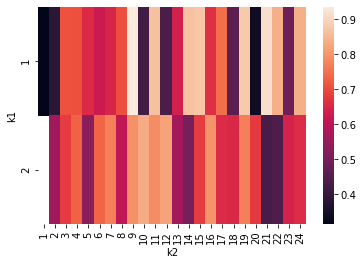

In [12]:
best_params = np.argmax(scores)
print("(BEST MODEL) k1=%s k2=%s coherence=%.2f"  %(params[best_params][0], params[best_params][1],  scores[best_params]))

data = pd.DataFrame(data={'k1':list(zip(*params))[0], 'k2':list(zip(*params))[1], 'score':scores})
data = data.pivot(index='k1', columns='k2', values='score')
sns.heatmap(data)
plt.show()

**1. Choose the best parameters**

In [13]:
#################################################
### Set the best model
best_k1 = params[best_params][0] 
best_k2 = params[best_params][1]
model = tp.PAModel(tw=tp.TermWeight.IDF, min_cf=5, k1=best_k1, k2=best_k2, corpus=corpus, seed=0)
model.burn_in=100
model.train(1000, workers=1)

**2. Print all the topics**

In [14]:
#############################################
#### Topics gonna be here 
for k in range(best_k2):
    print('Topic #{}'.format(k))
    print("\t", [w for w, _ in model.get_topic_words(k)])
        

Topic #0
	 ['bark', 'schr', 'brig', 'sept', 'liverpool', 'schrs', 'april', 'baltimore', 'ship', 'providence']
Topic #1
	 ['republican', 'committee', 'convention', 'shall', 'vote', 'government', 'president', 'governor', 'mayor', 'report']
Topic #2
	 ['funeral', 'invite', 'january', 'bushel', 'dull', 'relative', 'quiet', 'steady', 'february', 'march']
Topic #3
	 ['rent', 'floor', 'room', 'location', 'acre', 'sale', 'furniture', 'apply', 'sixth', 'story']
Topic #4
	 ['pier', 'july', 'freight', 'ticket', 'steerage', 'cabin', 'passage', 'north', 'excursion', 'august']
Topic #5
	 ['harness', 'wagon', 'prize', 'trot', 'horse', 'phaeton', 'warrant', 'prise', 'coupe', 'matinee']
Topic #6
	 ['church', 'preach', 'christ', 'baptist', 'episcopal', 'methodist', 'thing', 'lord', 'bishop', 'father']
Topic #7
	 ['cook', 'reference', 'girl', 'housework', 'respectable', 'woman', 'chambermaid', 'washing', 'situation', 'waitress']
Topic #8
	 ['prisoner', 'witness', 'judge', 'length', 'race', 'arrest', 'cou